<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Entrenamiento de redes *Feed-Forward* vı́a GD y variantes (SGD, mini-*batches*), *momentum*, regularización y tasa de aprendizaje adaptiva.
* Evaluación de redes *Feed-Forward* vı́a validación cruzada (cross-validation).
* Rol de capas ocultas y mayor profundidad (*Deep Learning*).
* Identificar el gradiente desvaneciente.
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 26 de Octubre.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<margarita.bugueno.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<cvalle@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea1-INF395-II-2018]

<hr style="height:2px;border:none"/>

#### Paquetes instalación

Para poder trabajar en el curso se necesitará instalar librerías para Python, por lo que se recomienda instalarlas a través de anaconda (para Windows y sistemas Unix) en un entorno virtual, donde podrán elegir su versión de Python. Se instalarán librerías como sklearn, una librería simple y de facil acceso para data science, keras en su versión con GPU (para cálculo acelerado a través de la tarjeta gráfica), además de que ésta utiliza como backend TensorFlow o Theano, por lo que habrá que instalar alguno de éstos, además de las librerías básicas de computer science como *numpy, matplotlib, pandas,* además de claramente *jupyter*.

* Descargar anacona
* Luego de instalar Anaconda y tenerla en el path de su computador crear un entorno virtual:
```
conda create -n redesneuronales python=version
```
con version, la version de Python que desea utilizar. Si está en Windows, se recomienda Python 3 debido a dependencias con una de las librerías a utilziar.

* Acceder al ambiente creado
```
source activate redesneuronales
```

* Instalar los paquetes a utilizar
```
conda install jupyter sklearn numpy pandas matplotlib keras-gpu tensorflow-gpu
```

*  Para salir del entorno
```
source deactivate redesneuronales
```

<hr style="height:2px;border:none"/>
La tarea se divide en secciones:

[1.](#primero) Predicción de Entalpía de Atomización  
[2.](#segundo) *Deep Networks*  
[3.](#tercero) Entendimiento de imágenes de personas

<a id="primero"></a>
## 1. Predicción de Entalpía de Atomización


Las simulaciones de propiedades moleculares son computacionalmente costosas y requieren de un arduo trabajo científico. El objetivo de esta sección corresponde a la utilización de métodos de aprendizaje automático supervisado (Redes Neuronales Artificiales) para predecir propiedades moleculares, en este caso la Energía de Atomización o Entalpía de Atomización, a partir de una base de datos de simulaciones obtenida mediante __[Quantum Espresso](http://www.quantum-espresso.org/)__. Si esto se lograse hacer con gran precisión, se abrirían muchas posibilidades en el diseño computacional y el descubrimiento de nuevas moléculas, compuestos y fármacos.

<img src="https://pubs.rsc.org/services/images/RSCpubs.ePlatform.Service.FreeContent.ImageService.svc/ImageService/Articleimage/2012/NR/c2nr11543c/c2nr11543c-f4.gif" title="Title text" width="40%"/>


La **entalpía de atomización** es la cantidad de variación de entalpía cuando los enlaces de un compuesto se rompen y los componentes se reducen a átomos individuales. Tal como se ha indicado, su tarea es la de predecir dicho nivel a partir de los atributos enunciados en el dataset puesto a vuestra disposición en *moodle*.

> a) Construya un *dataframe* con los datos a analizar y descríbalo brevemete. Además, realice la división de éste en los conjuntos de entrenamiento, validación y testeo correspondientes. Comente por qué se deben eliminar ciertas columnas.
```python
import pandas as pd
datos= pd.read_csv("EnergyMolecule/roboBohr.csv")
datos.shape
datos.info()
datos.describe()
...
datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)
total=len(datos)
df_train=datos[:int(0.6*total)]                       #60% de los datos
df_val=datos[int(0.6*total):int(0.85*total)]          #25% de los datos
df_test=datos[int(0.85*total)::]                      #15% restante
```
>> a.1) Una buena práctica es la de normalizar los datos antes de trabajar con el modelo. **Explique por qué se aconseja dicho preprocesamiento**
>```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
X_val_scaled =  pd.DataFrame(scaler.transform(df_val),columns=df_val.columns)
X_test_scaled =  pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
...
y_train = df_train.pop('Eat').values.reshape(-1,1)
y_val = df_val.pop('Eat').values.reshape(-1,1)
...
X_train_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_val_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_test_scaled.drop(columns=['Eat'],axis=1,inplace=True)
```

 
>b) Muestre en un gráfico el error cuadrático (MSE) para el conjunto de entrenamiento y de pruebas vs número de *epochs* de entrenamiento, para una red *feedforward* de 3 capas, con 256 unidades ocultas y función de activación sigmoidal. Entrene la red usando gradiente descendente estocástico con tasa de aprendizaje (learning rate) 0.01 y 250 epochs de entrenamiento, en el conjunto de entrenamiento y de validación. Comente. Si observara divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento.
```python
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
history = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
```
> c) Repita el paso anterior, utilizado ’**ReLU**’ como función de activación y compare con lo obtenido en b).  

> d) Repita b) y c) variando la tasa de aprendizaje (*learning rate*) en un rango sensible. Comente. Si observara divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento.
```python
import numpy as np
n_lr = 20
lear_rate = np.linspace(0,1,n_lr)
```

> e) Entrene los modelos considerados en b) y c) usando *progressive decay*. Compare y comente.
```python
n_decay = 10
lear_decay = np.logspace(-6,0,n_decay)
sgd = SGD(lr=0.2, decay=1e-6)
```

> f) Entrene los modelos considerados en b) y c) utilizando SGD en mini-*batches*. Experimente con diferentes tamaños del *batch*. Comente.
```python
n_batches = 21
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches))
model.fit(X_train_scaled,y_train,batch_size=50,epochs=250,validation_data=(X_val_scaled, y_val))
```
> g) Entrene los modelos obtenidos en b) y c) utilizando estrategias modernas para adaptar la tasa de aprendizaje. Compare los desempeños de adagrad, adadelta, RMSprop y adam. ¿Se observa en algún caso un mejor resultado final? ¿Se observa en algún caso una mayor velocidad de convergencia sobre el dataset de entrenamiento? ¿Sobre el dataset de validación?
```python
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
moptimizer = Adagrad(lr=0.01)
model.compile(optimizer=moptimizer)
model.fit(X_train_scaled,y_train,batch_size=bs,epochs=250,validation_data=(X_val_scaled, y_val))
```

> h) Entrene los modelos obtenidos en b) y c) utilizando regularizadores $l_1$ y $l_2$ (*weight decay*). Compare los desempeños de prueba obtenidos antes y después de regularizar. Experimente con distintos valores del parámetro de regularización y comente. Además evalúe el efecto de regularizar solo la primera capa *vs* la segunda, comente.
```python
model = Sequential()
...#la regularization se debe incorporar a cada capa separadamente
idim=X_train_scaled.shape[1]
model.add(Dense(256,input_dim=idim,kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('linear'))
```

> i) Entrene los modelos obtenidos en b) y c) utilizando *Dropout*. Compare los desempeños de prueba obtenidos antes y después de regularizar. Experimente con distintos valores del parámetro de regularización y comente.
```python
from keras.layers import Dropout
model = Sequential()
...
model.add(Dense(256,kernel_initializer='uniform'))
model.add(Activation('sigmoid'))
model.add(Dropout(0.2))
...
```

> j) Fijando todos los demás hiper-parámetros del modelo definido en b) y en c), utilice validación cruzada con un número de *folds* igual a *K* = 5 y *K*=10 para determinar el mejor valor correspondiente a un parámetro que usted elija (tasa de aprendizaje, número de neuronas, parámetro de regularización, etc) ¿El mejor parámetro para la red con sigmoidal es distinto que para ReLU? ¿Porqué sucede? Además mida el error real del modelo sobre el conjunto de pruebas, compare y concluya.
```python
from sklearn import cross_validation
Xm = X_train_scaled.values
ym = y_train
kfold = cross_validation.KFold(len(Xm), 10)
cvscores = []
for i, (train, val) in enumerate(kfold):
    ...# create model
    model = #model with hiperparam
    ...# Compile model
    model.compile(optimizer=,loss='mean_squared_error')
    ...# Fit the model
    model.fit(Xm[train], ym[train], epochs=250)
    ...# evaluate the model
    scores = model.evaluate(Xm[val], ym[val])
    cvscores.append(scores)
mse_cv = np.mean(cvscores)
```

# Respuesta Pregunta 1

a) Descripción de los datos

In [1]:
import pandas as pd
datos= pd.read_csv("roboBohr.csv")

datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)
total=len(datos)
df_train=datos[:int(0.6*total)]                       #60% de los datos
df_val=datos[int(0.6*total):int(0.85*total)]          #25% de los datos
df_test=datos[int(0.85*total)::]                      #15% restante

a.1) Normalizando

In [2]:
# Setting training and evaluation data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
X_val_scaled =  pd.DataFrame(scaler.transform(df_val),columns=df_val.columns)
X_test_scaled =  pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)

y_train = df_train.pop('Eat').values.reshape(-1,1)
y_val = df_val.pop('Eat').values.reshape(-1,1)

X_train_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_val_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_test_scaled.drop(columns=['Eat'],axis=1,inplace=True)

b)

In [3]:
# Creating and training model
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
model = Sequential()

/Users/cmaldona/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
history = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 209us/step - loss: 1.4463 - val_loss: 0.5312
Epoch 2/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.6106 - val_loss: 0.4332
Epoch 3/250
9745/9745 [==============================] - 2s 186us/step - loss: 0.4987 - val_loss: 0.3856
Epoch 4/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.4316 - val_loss: 0.3665
Epoch 5/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.3621 - val_loss: 0.3535
Epoch 6/250
9745/9745 [==============================] - 2s 213us/step - loss: 0.3243 - val_loss: 0.3013
Epoch 7/250
9745/9745 [==============================] - 2s 204us/step - loss: 0.2854 - val_loss: 0.2445
Epoch 8/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.2528 - val_loss: 0.2182
Epoch 9/250
9745/9745 [==============================] - 2s 168us/step - loss: 0.2193 - val_loss: 0.1962
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.0304 - val_loss: 0.0431
Epoch 79/250
9745/9745 [==============================] - 2s 178us/step - loss: 0.0299 - val_loss: 0.0551
Epoch 80/250
9745/9745 [==============================] - 2s 161us/step - loss: 0.0309 - val_loss: 0.0500
Epoch 81/250
9745/9745 [==============================] - 2s 181us/step - loss: 0.0293 - val_loss: 0.0463
Epoch 82/250
9745/9745 [==============================] - 2s 178us/step - loss: 0.0284 - val_loss: 0.0443
Epoch 83/250
9745/9745 [==============================] - 2s 198us/step - loss: 0.0288 - val_loss: 0.0423
Epoch 84/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0291 - val_loss: 0.0409
Epoch 85/250
9745/9745 [==============================] - 2s 154us/step - loss: 0.0289 - val_loss: 0.0496
Epoch 86/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.0278 - val_loss: 0.0712
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.0201 - val_loss: 0.0383
Epoch 156/250
9745/9745 [==============================] - 2s 196us/step - loss: 0.0203 - val_loss: 0.0363
Epoch 157/250
9745/9745 [==============================] - 2s 186us/step - loss: 0.0192 - val_loss: 0.0390
Epoch 158/250
9745/9745 [==============================] - 2s 165us/step - loss: 0.0198 - val_loss: 0.0380
Epoch 159/250
9745/9745 [==============================] - 2s 165us/step - loss: 0.0195 - val_loss: 0.0412
Epoch 160/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.0196 - val_loss: 0.0381
Epoch 161/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.0195 - val_loss: 0.0410
Epoch 162/250
9745/9745 [==============================] - 2s 167us/step - loss: 0.0189 - val_loss: 0.0593
Epoch 163/250
9745/9745 [==============================] - 2s 156us/step - loss: 0.0193 - val_loss: 0.0395
Epoch 164/250
9745/9745 [============

9745/9745 [==============================] - 1s 154us/step - loss: 0.0153 - val_loss: 0.0375
Epoch 232/250
9745/9745 [==============================] - 2s 155us/step - loss: 0.0155 - val_loss: 0.0384
Epoch 233/250
9745/9745 [==============================] - 2s 155us/step - loss: 0.0155 - val_loss: 0.0385
Epoch 234/250
9745/9745 [==============================] - 2s 156us/step - loss: 0.0159 - val_loss: 0.0345
Epoch 235/250
9745/9745 [==============================] - 2s 154us/step - loss: 0.0150 - val_loss: 0.0371
Epoch 236/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.0160 - val_loss: 0.0367
Epoch 237/250
9745/9745 [==============================] - 2s 157us/step - loss: 0.0154 - val_loss: 0.0359
Epoch 238/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.0151 - val_loss: 0.0348
Epoch 239/250
9745/9745 [==============================] - 2s 160us/step - loss: 0.0152 - val_loss: 0.0347
Epoch 240/250
9745/9745 [==========================

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

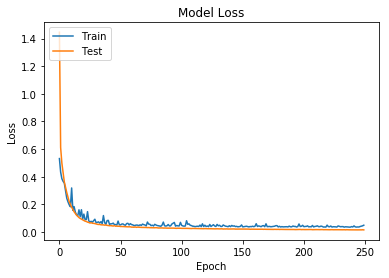

In [6]:
# Ploting Loss And Val_Loss

# Data
val_loss = history.history['val_loss']
loss = history.history['loss']

# Ploting
plt.plot(val_loss)
plt.plot(loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#fig.savefig("test.png")
plt.show()


c)

In [10]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=SGD(lr=0.001),loss='mean_squared_error')
history2 = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 176us/step - loss: 10.2817 - val_loss: 2.4034
Epoch 2/250
9745/9745 [==============================] - 2s 166us/step - loss: 1.6026 - val_loss: 1.6458
Epoch 3/250
9745/9745 [==============================] - 2s 164us/step - loss: 0.8790 - val_loss: 1.0036
Epoch 4/250
9745/9745 [==============================] - 2s 165us/step - loss: 0.5400 - val_loss: 0.9441
Epoch 5/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.5774 - val_loss: 0.9980
Epoch 6/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.4463 - val_loss: 0.7764
Epoch 7/250
9745/9745 [==============================] - 2s 156us/step - loss: 0.3509 - val_loss: 1.1096
Epoch 8/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.2892 - val_loss: 0.7060
Epoch 9/250
9745/9745 [==============================] - 2s 191us/step - loss: 0.2651 - val_loss: 0.7830
Epoch 

Epoch 78/250
9745/9745 [==============================] - 2s 154us/step - loss: 0.0549 - val_loss: 0.1381
Epoch 79/250
9745/9745 [==============================] - 2s 155us/step - loss: 0.0495 - val_loss: 0.1512
Epoch 80/250
9745/9745 [==============================] - 2s 155us/step - loss: 0.0488 - val_loss: 0.1423
Epoch 81/250
9745/9745 [==============================] - 2s 168us/step - loss: 0.0472 - val_loss: 0.1549
Epoch 82/250
9745/9745 [==============================] - 2s 190us/step - loss: 0.0459 - val_loss: 0.1357
Epoch 83/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.0502 - val_loss: 0.1376
Epoch 84/250
9745/9745 [==============================] - 2s 162us/step - loss: 0.0495 - val_loss: 0.1816
Epoch 85/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.0492 - val_loss: 0.1317
Epoch 86/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.0477 - val_loss: 0.1513
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 2s 175us/step - loss: 0.0315 - val_loss: 0.1057
Epoch 156/250
9745/9745 [==============================] - 1s 149us/step - loss: 0.0301 - val_loss: 0.1259
Epoch 157/250
9745/9745 [==============================] - 1s 151us/step - loss: 0.0296 - val_loss: 0.1032
Epoch 158/250
9745/9745 [==============================] - 2s 156us/step - loss: 0.0294 - val_loss: 0.1071
Epoch 159/250
9745/9745 [==============================] - 2s 159us/step - loss: 0.0291 - val_loss: 0.1554
Epoch 160/250
9745/9745 [==============================] - 1s 151us/step - loss: 0.0295 - val_loss: 0.1057
Epoch 161/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.0289 - val_loss: 0.1163
Epoch 162/250
9745/9745 [==============================] - 2s 165us/step - loss: 0.0282 - val_loss: 0.1286
Epoch 163/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.0286 - val_loss: 0.1130
Epoch 164/250
9745/9745 [============

9745/9745 [==============================] - 2s 177us/step - loss: 0.0232 - val_loss: 0.1077
Epoch 232/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.0227 - val_loss: 0.1121
Epoch 233/250
9745/9745 [==============================] - 1s 152us/step - loss: 0.0230 - val_loss: 0.1148
Epoch 234/250
9745/9745 [==============================] - 1s 152us/step - loss: 0.0219 - val_loss: 0.1094
Epoch 235/250
9745/9745 [==============================] - 2s 155us/step - loss: 0.0223 - val_loss: 0.1195
Epoch 236/250
9745/9745 [==============================] - 2s 156us/step - loss: 0.0227 - val_loss: 0.1101
Epoch 237/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.0216 - val_loss: 0.1072
Epoch 238/250
9745/9745 [==============================] - 2s 167us/step - loss: 0.0218 - val_loss: 0.1084
Epoch 239/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.0221 - val_loss: 0.1044
Epoch 240/250
9745/9745 [==========================

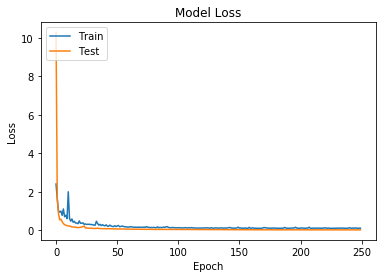

In [11]:
# Ploting Loss And Val_Loss

# Data
val_loss = history2.history['val_loss']
loss = history2.history['loss']

# Ploting
plt.plot(val_loss)
plt.plot(loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#fig.savefig("test.png")
plt.show()

d)

In [12]:
histories = dict() # Key = learn_rate, Value = history
n_lr = 20
learn_rate = np.linspace(0,1,n_lr)
for learn_r in learn_rate:
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=SGD(lr=learn_r),loss='mean_squared_error')
    history = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
    histories['loss('+str(learn_r)+')'] = history.history['loss']
    histories['val loss('+str(learn_r)+')'] = history.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-D-1.csv')

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 217us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 2/250
9745/9745 [==============================] - 2s 217us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 3/250
9745/9745 [==============================] - 2s 212us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 4/250
9745/9745 [==============================] - 2s 161us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 5/250
9745/9745 [==============================] - 2s 157us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 6/250
9745/9745 [==============================] - 2s 176us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 7/250
9745/9745 [==============================] - 2s 176us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 8/250
9745/9745 [==============================] - 2s 171us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 9/250
9745/9745 [==============================] - 2s 157us/step - loss: 1

9745/9745 [==============================] - 2s 165us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 76/250
9745/9745 [==============================] - 2s 157us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 77/250
9745/9745 [==============================] - 2s 171us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 78/250
9745/9745 [==============================] - 2s 169us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 79/250
9745/9745 [==============================] - 2s 173us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 80/250
9745/9745 [==============================] - 2s 159us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 81/250
9745/9745 [==============================] - 2s 168us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 82/250
9745/9745 [==============================] - 2s 166us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 83/250
9745/9745 [==============================] - 2s 174us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 84/250
9745/9745 

9745/9745 [==============================] - 2s 162us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 150/250
9745/9745 [==============================] - 2s 173us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 151/250
9745/9745 [==============================] - 2s 168us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 152/250
9745/9745 [==============================] - 2s 163us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 153/250
9745/9745 [==============================] - 2s 164us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 154/250
9745/9745 [==============================] - 2s 171us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 155/250
9745/9745 [==============================] - 2s 186us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 156/250
9745/9745 [==============================] - 2s 177us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 157/250
9745/9745 [==============================] - 2s 167us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 158/250
9

Epoch 223/250
9745/9745 [==============================] - 2s 155us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 224/250
9745/9745 [==============================] - 2s 154us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 225/250
9745/9745 [==============================] - 2s 159us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 226/250
9745/9745 [==============================] - 1s 153us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 227/250
9745/9745 [==============================] - 1s 153us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 228/250
9745/9745 [==============================] - 2s 157us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 229/250
9745/9745 [==============================] - 2s 155us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 230/250
9745/9745 [==============================] - 2s 154us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 231/250
9745/9745 [==============================] - 2s 158us/step - loss: 135.1554 - val_loss: 154.6922
E

9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 52/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 53/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 54/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 55/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 56/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 57/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 58/250
9745/9745 [==============================] - 2s 154us/step - loss: nan - val_loss: nan
Epoch 59/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 60/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 61/250


9745/9745 [==============================] - 2s 220us/step - loss: nan - val_loss: nan
Epoch 133/250
9745/9745 [==============================] - 2s 207us/step - loss: nan - val_loss: nan
Epoch 134/250
9745/9745 [==============================] - 2s 183us/step - loss: nan - val_loss: nan
Epoch 135/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 136/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 137/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 138/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 139/250
9745/9745 [==============================] - 1s 154us/step - loss: nan - val_loss: nan
Epoch 140/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 141/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 214/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 215/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 216/250
9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 217/250
9745/9745 [==============================] - 2s 235us/step - loss: nan - val_loss: nan
Epoch 218/250
9745/9745 [==============================] - 2s 201us/step - loss: nan - val_loss: nan
Epoch 219/250
9745/9745 [==============================] - 2s 189us/step - loss: nan - val_loss: nan
Epoch 220/250
9745/9745 [==============================] - 2s 254us/step - loss: nan - val_loss: nan
Epoch 221/250
9745/9745 [==============================] - 2s 212us/step - loss: nan - val_loss: nan
Epoch 222/250
9745/9745 [==============================] - 3s 293us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 208us/step - loss: nan - val_loss: nan
Epoch 45/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 46/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 47/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 48/250
9745/9745 [==============================] - 2s 179us/step - loss: nan - val_loss: nan
Epoch 49/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 50/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 51/250
9745/9745 [==============================] - 1s 153us/step - loss: nan - val_loss: nan
Epoch 52/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 53/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 54/250


Epoch 126/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 130/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 131/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 132/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 133/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 134/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 135/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_

9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 1s 154us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 214/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 215/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 216/250
9745/9745 [==============================] - 1s 154us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 39/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 40/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 41/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 42/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 43/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 44/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 45/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 46/250
9745/9745 [==============================] - 2s 179us/step - loss: nan - val_loss: nan
Epoch 47/250
9745/9745 [==============================] - 2s 182us/step - loss: nan - val_loss: nan
Epoch 48/250


Epoch 120/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_

9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 33/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 34/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 35/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 36/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 37/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 38/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 39/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 40/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 41/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 42/250


Epoch 114/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_

9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 30/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 31/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 32/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 33/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 34/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 35/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 36/250


Epoch 108/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_

9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 190/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 191/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 192/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 193/250
9745/9745 [==============================] - 2s 191us/step - loss: nan - val_loss: nan
Epoch 194/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 195/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 30/250


9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 184/250
9745/9745 [==============================] - 2s 213us/step - loss: nan - val_loss: nan
Epoch 185/250
9745/9745 [==============================] - 2s 208us/step - loss: nan - val_loss: nan
Epoch 186/250
9745/9745 [==============================] - 2s 210us/step - loss: nan - val_loss: nan
Epoch 187/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 188/250
9745/9745 [==============================] - 2s 191us/step - loss: nan - val_loss: nan
Epoch 189/250
9745/9745 [==============================] - 2s 182us/step - loss: nan - val_loss: nan
Epoch 190/250
9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 191/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 192/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoc

Epoch 14/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 15/250
9745/9745 [==============================] - 2s 198us/step - loss: nan - val_loss: nan
Epoch 16/250
9745/9745 [==============================] - 2s 193us/step - loss: nan - val_loss: nan
Epoch 17/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 18/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 19/250
9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 20/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 206us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 188us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 182us/step - loss: nan - val_loss: nan


Epoch 96/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 97/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 98/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 99/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 100/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 101/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 102/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss

9745/9745 [==============================] - 2s 206us/step - loss: nan - val_loss: nan
Epoch 178/250
9745/9745 [==============================] - 2s 205us/step - loss: nan - val_loss: nan
Epoch 179/250
9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 180/250
9745/9745 [==============================] - 2s 189us/step - loss: nan - val_loss: nan
Epoch 181/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 182/250
9745/9745 [==============================] - 2s 198us/step - loss: nan - val_loss: nan
Epoch 183/250
9745/9745 [==============================] - 2s 218us/step - loss: nan - val_loss: nan
Epoch 184/250
9745/9745 [==============================] - 2s 183us/step - loss: nan - val_loss: nan
Epoch 185/250
9745/9745 [==============================] - 2s 185us/step - loss: nan - val_loss: nan
Epoch 186/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoc

Epoch 8/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 9/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 10/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 11/250
9745/9745 [==============================] - 2s 185us/step - loss: nan - val_loss: nan
Epoch 12/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 13/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 14/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 15/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 16/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 17/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Ep

Epoch 90/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 91/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 92/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 93/250
9745/9745 [==============================] - 2s 179us/step - loss: nan - val_loss: nan
Epoch 94/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 95/250
9745/9745 [==============================] - 1s 149us/step - loss: nan - val_loss: nan
Epoch 96/250
9745/9745 [==============================] - 1s 149us/step - loss: nan - val_loss: nan
Epoch 97/250
9745/9745 [==============================] - 1s 154us/step - loss: nan - val_loss: nan
Epoch 98/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 99/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan


9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 172/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 173/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 174/250
9745/9745 [==============================] - 1s 154us/step - loss: nan - val_loss: nan
Epoch 175/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 176/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 177/250
9745/9745 [==============================] - 1s 152us/step - loss: nan - val_loss: nan
Epoch 178/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 179/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 180/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 2/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 3/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 4/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 5/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 6/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 7/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 8/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 9/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 10/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 11/250
9745/974

9745/9745 [==============================] - 2s 191us/step - loss: nan - val_loss: nan
Epoch 84/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 85/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 86/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 87/250
9745/9745 [==============================] - 2s 184us/step - loss: nan - val_loss: nan
Epoch 88/250
9745/9745 [==============================] - 2s 200us/step - loss: nan - val_loss: nan
Epoch 89/250
9745/9745 [==============================] - 2s 203us/step - loss: nan - val_loss: nan
Epoch 90/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 91/250
9745/9745 [==============================] - 2s 209us/step - loss: nan - val_loss: nan
Epoch 92/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 93/250


9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 165/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 166/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 167/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 168/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 169/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 170/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 171/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 172/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 173/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 246/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 247/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 248/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 249/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 250/250
9745/9745 [==============================] - 2s 185us/step - loss: nan - val_loss: nan
Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 216us/step - loss: nan - val_loss: nan
Epoch 2/250
9745/9745 [==============================] - 2s 188us/step - loss: nan - val_loss: nan
Epoch 3/250
9745/9745 [==============================] - 2s 189us/step - loss: nan - val_loss: nan
Epoch 4/250
9745/9745 [==============================] - 2s 193

9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 77/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 78/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 79/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 80/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 81/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 82/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 83/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 84/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 85/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 86/250


9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 158/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 159/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 160/250
9745/9745 [==============================] - 2s 216us/step - loss: nan - val_loss: nan
Epoch 161/250
9745/9745 [==============================] - 2s 196us/step - loss: nan - val_loss: nan
Epoch 162/250
9745/9745 [==============================] - 2s 205us/step - loss: nan - val_loss: nan
Epoch 163/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 164/250
9745/9745 [==============================] - 2s 216us/step - loss: nan - val_loss: nan
Epoch 165/250
9745/9745 [==============================] - 2s 182us/step - loss: nan - val_loss: nan
Epoch 166/250
9745/9745 [==============================] - 2s 197us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 239/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 240/250
9745/9745 [==============================] - 2s 179us/step - loss: nan - val_loss: nan
Epoch 241/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 242/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 243/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 244/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 245/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 246/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 247/250
9745/9745 [==============================] - 2s 183us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 181us/step - loss: nan - val_loss: nan
Epoch 70/250
9745/9745 [==============================] - 2s 193us/step - loss: nan - val_loss: nan
Epoch 71/250
9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 72/250
9745/9745 [==============================] - 2s 184us/step - loss: nan - val_loss: nan
Epoch 73/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 74/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 75/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 76/250
9745/9745 [==============================] - 2s 204us/step - loss: nan - val_loss: nan
Epoch 77/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 78/250
9745/9745 [==============================] - 2s 203us/step - loss: nan - val_loss: nan
Epoch 79/250


9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 151/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 152/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 153/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 154/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 155/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 156/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 157/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 158/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 159/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 232/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 233/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 234/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 235/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 236/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 237/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 238/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 239/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 240/250
9745/9745 [==============================] - 2s 181us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 218us/step - loss: nan - val_loss: nan
Epoch 63/250
9745/9745 [==============================] - 2s 196us/step - loss: nan - val_loss: nan
Epoch 64/250
9745/9745 [==============================] - 2s 205us/step - loss: nan - val_loss: nan
Epoch 65/250
9745/9745 [==============================] - 2s 211us/step - loss: nan - val_loss: nan
Epoch 66/250
9745/9745 [==============================] - 2s 204us/step - loss: nan - val_loss: nan
Epoch 67/250
9745/9745 [==============================] - 2s 250us/step - loss: nan - val_loss: nan
Epoch 68/250
9745/9745 [==============================] - 2s 219us/step - loss: nan - val_loss: nan
Epoch 69/250
9745/9745 [==============================] - 2s 235us/step - loss: nan - val_loss: nan
Epoch 70/250
9745/9745 [==============================] - 3s 259us/step - loss: nan - val_loss: nan
Epoch 71/250
9745/9745 [==============================] - 2s 226us/step - loss: nan - val_loss: nan
Epoch 72/250


9745/9745 [==============================] - 2s 206us/step - loss: nan - val_loss: nan
Epoch 144/250
9745/9745 [==============================] - 2s 205us/step - loss: nan - val_loss: nan
Epoch 145/250
9745/9745 [==============================] - 2s 191us/step - loss: nan - val_loss: nan
Epoch 146/250
9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 147/250
9745/9745 [==============================] - 2s 185us/step - loss: nan - val_loss: nan
Epoch 148/250
9745/9745 [==============================] - 2s 188us/step - loss: nan - val_loss: nan
Epoch 149/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 150/250
9745/9745 [==============================] - 2s 199us/step - loss: nan - val_loss: nan
Epoch 151/250
9745/9745 [==============================] - 2s 196us/step - loss: nan - val_loss: nan
Epoch 152/250
9745/9745 [==============================] - 2s 207us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 225/250
9745/9745 [==============================] - 2s 200us/step - loss: nan - val_loss: nan
Epoch 226/250
9745/9745 [==============================] - 2s 191us/step - loss: nan - val_loss: nan
Epoch 227/250
9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 228/250
9745/9745 [==============================] - 2s 208us/step - loss: nan - val_loss: nan
Epoch 229/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 230/250
9745/9745 [==============================] - 2s 220us/step - loss: nan - val_loss: nan
Epoch 231/250
9745/9745 [==============================] - 2s 214us/step - loss: nan - val_loss: nan
Epoch 232/250
9745/9745 [==============================] - 2s 204us/step - loss: nan - val_loss: nan
Epoch 233/250
9745/9745 [==============================] - 2s 189us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 56/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 57/250
9745/9745 [==============================] - 2s 207us/step - loss: nan - val_loss: nan
Epoch 58/250
9745/9745 [==============================] - 2s 209us/step - loss: nan - val_loss: nan
Epoch 59/250
9745/9745 [==============================] - 2s 224us/step - loss: nan - val_loss: nan
Epoch 60/250
9745/9745 [==============================] - 2s 204us/step - loss: nan - val_loss: nan
Epoch 61/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 62/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 63/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 64/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 65/250


9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 137/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 138/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 139/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 140/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 141/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 142/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 143/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 144/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 145/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 218/250
9745/9745 [==============================] - 2s 179us/step - loss: nan - val_loss: nan
Epoch 219/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 220/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 221/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 222/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 223/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 224/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 225/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 226/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 49/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 50/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 51/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 52/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 53/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 54/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 55/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 56/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 57/250
9745/9745 [==============================] - 2s 185us/step - loss: nan - val_loss: nan
Epoch 58/250


9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 130/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 131/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 132/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 133/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 134/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 135/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 136/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 137/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 138/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 214/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 215/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 216/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 217/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 218/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 219/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 256us/step - loss: nan - val_loss: nan
Epoch 42/250
9745/9745 [==============================] - 3s 260us/step - loss: nan - val_loss: nan
Epoch 43/250
9745/9745 [==============================] - 2s 193us/step - loss: nan - val_loss: nan
Epoch 44/250
9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 45/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 46/250
9745/9745 [==============================] - 2s 238us/step - loss: nan - val_loss: nan
Epoch 47/250
9745/9745 [==============================] - 2s 210us/step - loss: nan - val_loss: nan
Epoch 48/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 49/250
9745/9745 [==============================] - 2s 214us/step - loss: nan - val_loss: nan
Epoch 50/250
9745/9745 [==============================] - 2s 185us/step - loss: nan - val_loss: nan
Epoch 51/250


Epoch 123/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 208us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 197us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 216us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 196us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 204us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 130/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 131/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 132/250
9745/9745 [==============================] - 2s 183us/step - loss: nan - val_

9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 182us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 181us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 206us/step - loss: nan - val_loss: nan
Epoch 36/250
9745/9745 [==============================] - 2s 201us/step - loss: nan - val_loss: nan
Epoch 37/250
9745/9745 [==============================] - 2s 240us/step - loss: nan - val_loss: nan
Epoch 38/250
9745/9745 [==============================] - 2s 221us/step - loss: nan - val_loss: nan
Epoch 39/250
9745/9745 [==============================] - 2s 212us/step - loss: nan - val_loss: nan
Epoch 40/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 41/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 42/250
9745/9745 [==============================] - 2s 212us/step - loss: nan - val_loss: nan
Epoch 43/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 44/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 45/250


Epoch 117/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_

9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 30/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 31/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 32/250
9745/9745 [==============================] - 2s 154us/step - loss: nan - val_loss: nan
Epoch 33/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 34/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 35/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 36/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 37/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 38/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 39/250


Epoch 111/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 154us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_

9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 193/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 194/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 195/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 30/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 31/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 32/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 33/250


9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 187/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 188/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 189/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 190/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 191/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 192/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 193/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 194/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 195/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 18/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 19/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 20/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 27/250


9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 100/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 101/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 102/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 181/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 182/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 183/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 184/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 185/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 186/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 187/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 188/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 189/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoc

AttributeError: module 'pandas' has no attribute 'Dataframe'

In [13]:
histories2 = dict() # Key = learn_rate, Value = history
n_lr = 20
learn_rate = np.linspace(0,1,n_lr)
for learn_r in learn_rate:
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=SGD(lr=learn_r),loss='mean_squared_error')
    history2 = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
    histories2['loss('+str(learn_r)+')'] = history2.history['loss']
    histories2['val loss('+str(learn_r)+')'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-D-2.csv')

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 241us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 2/250
9745/9745 [==============================] - 2s 195us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 3/250
9745/9745 [==============================] - 2s 217us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 4/250
9745/9745 [==============================] - 2s 202us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 5/250
9745/9745 [==============================] - 2s 178us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 6/250
9745/9745 [==============================] - 2s 207us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 7/250
9745/9745 [==============================] - 2s 197us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 8/250
9745/9745 [==============================] - 2s 189us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 9/250
9745/9745 [==============================] - 2s 176us/step - loss: 1

9745/9745 [==============================] - 2s 194us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 76/250
9745/9745 [==============================] - 2s 187us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 77/250
9745/9745 [==============================] - 1s 152us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 78/250
9745/9745 [==============================] - 2s 165us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 79/250
9745/9745 [==============================] - 2s 215us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 80/250
9745/9745 [==============================] - 2s 252us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 81/250
9745/9745 [==============================] - 3s 267us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 82/250
9745/9745 [==============================] - 2s 220us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 83/250
9745/9745 [==============================] - 3s 326us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 84/250
9745/9745 

9745/9745 [==============================] - 2s 227us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 150/250
9745/9745 [==============================] - 2s 172us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 151/250
9745/9745 [==============================] - 2s 176us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 152/250
9745/9745 [==============================] - 2s 171us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 153/250
9745/9745 [==============================] - 2s 163us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 154/250
9745/9745 [==============================] - 2s 173us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 155/250
9745/9745 [==============================] - 2s 159us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 156/250
9745/9745 [==============================] - 2s 158us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 157/250
9745/9745 [==============================] - 2s 159us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 158/250
9

Epoch 223/250
9745/9745 [==============================] - 2s 165us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 224/250
9745/9745 [==============================] - 2s 156us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 225/250
9745/9745 [==============================] - 2s 160us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 226/250
9745/9745 [==============================] - 2s 166us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 227/250
9745/9745 [==============================] - 2s 158us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 228/250
9745/9745 [==============================] - 2s 157us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 229/250
9745/9745 [==============================] - 2s 163us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 230/250
9745/9745 [==============================] - 2s 160us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 231/250
9745/9745 [==============================] - 2s 161us/step - loss: 135.7536 - val_loss: 154.1756
E

9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 52/250
9745/9745 [==============================] - 2s 188us/step - loss: nan - val_loss: nan
Epoch 53/250
9745/9745 [==============================] - 2s 184us/step - loss: nan - val_loss: nan
Epoch 54/250
9745/9745 [==============================] - 2s 199us/step - loss: nan - val_loss: nan
Epoch 55/250
9745/9745 [==============================] - 2s 181us/step - loss: nan - val_loss: nan
Epoch 56/250
9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 57/250
9745/9745 [==============================] - 2s 191us/step - loss: nan - val_loss: nan
Epoch 58/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 59/250
9745/9745 [==============================] - 2s 200us/step - loss: nan - val_loss: nan
Epoch 60/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 61/250


9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 133/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 134/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 135/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 136/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 137/250
9745/9745 [==============================] - 2s 184us/step - loss: nan - val_loss: nan
Epoch 138/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 139/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 140/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 141/250
9745/9745 [==============================] - 2s 200us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 214/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 215/250
9745/9745 [==============================] - 2s 226us/step - loss: nan - val_loss: nan
Epoch 216/250
9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 217/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 218/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 219/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 220/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 221/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 222/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 225us/step - loss: nan - val_loss: nan
Epoch 45/250
9745/9745 [==============================] - 2s 198us/step - loss: nan - val_loss: nan
Epoch 46/250
9745/9745 [==============================] - 2s 198us/step - loss: nan - val_loss: nan
Epoch 47/250
9745/9745 [==============================] - 2s 201us/step - loss: nan - val_loss: nan
Epoch 48/250
9745/9745 [==============================] - 2s 197us/step - loss: nan - val_loss: nan
Epoch 49/250
9745/9745 [==============================] - 2s 197us/step - loss: nan - val_loss: nan
Epoch 50/250
9745/9745 [==============================] - 2s 183us/step - loss: nan - val_loss: nan
Epoch 51/250
9745/9745 [==============================] - 2s 193us/step - loss: nan - val_loss: nan
Epoch 52/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 53/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 54/250


Epoch 126/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 130/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 131/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 132/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 133/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 134/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 135/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_

9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 214/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 215/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 216/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 39/250
9745/9745 [==============================] - 2s 218us/step - loss: nan - val_loss: nan
Epoch 40/250
9745/9745 [==============================] - 2s 179us/step - loss: nan - val_loss: nan
Epoch 41/250
9745/9745 [==============================] - 2s 196us/step - loss: nan - val_loss: nan
Epoch 42/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 43/250
9745/9745 [==============================] - 2s 225us/step - loss: nan - val_loss: nan
Epoch 44/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 45/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 46/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 47/250
9745/9745 [==============================] - 2s 193us/step - loss: nan - val_loss: nan
Epoch 48/250


Epoch 120/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 210us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 236us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 216us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 196us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 220us/step - loss: nan - val_

9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 33/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 34/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 35/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 36/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 37/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 38/250
9745/9745 [==============================] - 2s 181us/step - loss: nan - val_loss: nan
Epoch 39/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 40/250
9745/9745 [==============================] - 2s 201us/step - loss: nan - val_loss: nan
Epoch 41/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 42/250


Epoch 114/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_

9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 30/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 31/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 32/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 33/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 34/250
9745/9745 [==============================] - 2s 206us/step - loss: nan - val_loss: nan
Epoch 35/250
9745/9745 [==============================] - 2s 238us/step - loss: nan - val_loss: nan
Epoch 36/250


Epoch 108/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_

9745/9745 [==============================] - 2s 191us/step - loss: nan - val_loss: nan
Epoch 190/250
9745/9745 [==============================] - 2s 209us/step - loss: nan - val_loss: nan
Epoch 191/250
9745/9745 [==============================] - 2s 221us/step - loss: nan - val_loss: nan
Epoch 192/250
9745/9745 [==============================] - 2s 212us/step - loss: nan - val_loss: nan
Epoch 193/250
9745/9745 [==============================] - 2s 205us/step - loss: nan - val_loss: nan
Epoch 194/250
9745/9745 [==============================] - 2s 204us/step - loss: nan - val_loss: nan
Epoch 195/250
9745/9745 [==============================] - 2s 213us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 214us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 30/250


9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 184/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 185/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 186/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 187/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 188/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 189/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 190/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 191/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 192/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoc

Epoch 14/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 15/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 16/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 17/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 18/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 19/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 20/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan


Epoch 96/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 97/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 98/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 99/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 100/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 101/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 102/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss

9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 178/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 179/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 180/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 181/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 182/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 183/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 184/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 185/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 186/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoc

Epoch 8/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 9/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 10/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 11/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 12/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 13/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 14/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 15/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 16/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 17/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Ep

Epoch 90/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 91/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 92/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 93/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 94/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 95/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 96/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 97/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 98/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 99/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan


9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 172/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 173/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 174/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 175/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 176/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 177/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 178/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 179/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 180/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 232us/step - loss: nan - val_loss: nan
Epoch 2/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 3/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 4/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 5/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 6/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 7/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 8/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 9/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 10/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 11/250
9745/974

9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 84/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 85/250
9745/9745 [==============================] - 2s 179us/step - loss: nan - val_loss: nan
Epoch 86/250
9745/9745 [==============================] - 2s 198us/step - loss: nan - val_loss: nan
Epoch 87/250
9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 88/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 89/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 90/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 91/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 92/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 93/250


9745/9745 [==============================] - 2s 201us/step - loss: nan - val_loss: nan
Epoch 165/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 166/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 167/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 168/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 169/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 170/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 171/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 172/250
9745/9745 [==============================] - 2s 216us/step - loss: nan - val_loss: nan
Epoch 173/250
9745/9745 [==============================] - 3s 257us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 246/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 247/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 248/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 249/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 250/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 237us/step - loss: nan - val_loss: nan
Epoch 2/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 3/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 4/250
9745/9745 [==============================] - 2s 170

9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 77/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 78/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 79/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 80/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 81/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 82/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 83/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 84/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 85/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 86/250


9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 158/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 159/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 160/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 161/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 162/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 163/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 164/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 165/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 166/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 239/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 240/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 241/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 242/250
9745/9745 [==============================] - 2s 208us/step - loss: nan - val_loss: nan
Epoch 243/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 244/250
9745/9745 [==============================] - 2s 197us/step - loss: nan - val_loss: nan
Epoch 245/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 246/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 247/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 70/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 71/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 72/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 73/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 74/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 75/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 76/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 77/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 78/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 79/250


9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 151/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 152/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 153/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 154/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 155/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 156/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 157/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 158/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 159/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 232/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 233/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 234/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 235/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 236/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 237/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 238/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 239/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 240/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 63/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 64/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 65/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 66/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 67/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 68/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 69/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 70/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 71/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 72/250


9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 144/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 145/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 146/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 147/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 148/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 149/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 150/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 151/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 152/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 225/250
9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 226/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 227/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 228/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 229/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 230/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 231/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 232/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 233/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 56/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 57/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 58/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 59/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 60/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 61/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 62/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 63/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 64/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 65/250


9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 137/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 138/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 139/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 140/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 141/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 142/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 143/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 144/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 145/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 218/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 219/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 220/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 221/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 222/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 223/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 224/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 225/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 226/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 49/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 50/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 51/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 52/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 53/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 54/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 55/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 56/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 57/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 58/250


9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 130/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 131/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 132/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 133/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 134/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 135/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 136/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 137/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 138/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 214/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 215/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 216/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 217/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 218/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 219/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 42/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 43/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 44/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 45/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 46/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 47/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 48/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 49/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 50/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 51/250


Epoch 123/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 130/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 131/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 132/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_

9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 36/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 37/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 38/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 39/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 40/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 41/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 42/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 43/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 44/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 45/250


Epoch 117/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_

9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 30/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 31/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 32/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 33/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 34/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 35/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 36/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 37/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 38/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 39/250


Epoch 111/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_

9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 193/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 194/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 195/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 30/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 31/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 32/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 33/250


9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 187/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 188/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 189/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 190/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 191/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 192/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 193/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 194/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 195/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 18/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 19/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 20/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 27/250


9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 100/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 101/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 102/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 181/250
9745/9745 [==============================] - 2s 184us/step - loss: nan - val_loss: nan
Epoch 182/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 183/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 184/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 185/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 186/250
9745/9745 [==============================] - 2s 181us/step - loss: nan - val_loss: nan
Epoch 187/250
9745/9745 [==============================] - 2s 181us/step - loss: nan - val_loss: nan
Epoch 188/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 189/250
9745/9745 [==============================] - 2s 203us/step - loss: nan - val_loss: nan
Epoc

e) Progressive Decay

In [ ]:
n_decay = 10
histories = dict() 
histories2 = dict() 

for dec in np.logspace(-6,0,n_decay)
    sgd = SGD(lr=0.001, decay=dec)
    # model 1
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    history = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
    histories['loss('+str(dec)+')'] = history.history['loss']
    histories['val loss('+str(dec)+')'] = history.history['val_loss']
    # model 2
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    history2 = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
    histories2['loss('+str(dec)+')'] = history2.history['loss']
    histories2['val loss('+str(dec)+')'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-E-1.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-E-2.csv')

f) Sizes of batchs

In [ ]:
n_batches = 21
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches))

for sz in batch_sizes:
    sgd = SGD(lr=0.01)
    # model 1
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
    histories['loss('+str(learn_n)+')'] = history.history['loss']
    histories['val loss('+str(learn_)+')'] = history.history['val_loss']
    # model 2
    sgd = SGD(lr=0.001)
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=1, validation_data=(X_val_scaled, y_val))
    histories2['loss('+str(sz)+')'] = history2.history['loss']
    histories2['val loss('+str(sz)+')'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-F-1.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-F-2.csv')

g) Differents Methods

In [ ]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta

sz = 32

# model 1 (Adagrad)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    
moptimizer = Adagrad(lr=0.01)
model.compile(optimizer=moptimizer)
    
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

# model 2 (Adagrad)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

moptimizer = Adagrad(lr=0.001)
model.compile(optimizer=moptimizer)

history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-G-1-Adagrad.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-G-2-Adagrad.csv')

In [ ]:
# model 1 (Adam)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    
moptimizer = Adam(lr=0.01)
model.compile(optimizer=moptimizer)
    
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

# model 2 (Adam)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

moptimizer = Adam(lr=0.001)
model.compile(optimizer=moptimizer)

history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-G-1-Adam.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-G-2-Adam.csv')

In [ ]:
# model 1 (Adadelta)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    
moptimizer = Adadelta(lr=0.01)
model.compile(optimizer=moptimizer)
    
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

# model 2 (Adadelta)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

moptimizer = Adadelta(lr=0.001)
model.compile(optimizer=moptimizer)

history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']
    
df_aux = pd.Dataframe(histories)
df_aux.to_csv('1-G-1-Adadelta.csv')
df_aux = pd.Dataframe(histories2)
df_aux.to_csv('1-G-2-Adadelta.csv')

In [ ]:
# model 1 (RMSprop)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    
moptimizer = Adadelta(lr=0.01)
model.compile(optimizer=moptimizer)
    
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

# model 2 (RMSprop)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

moptimizer = RMSprop(lr=0.001)
model.compile(optimizer=moptimizer)

history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']
    
df_aux = pd.Dataframe(histories)
df_aux.to_csv('1-G-1-RMSprop.csv')
    df_aux = pd.Dataframe(histories2jh 
df_aux.to_csv('1-G-2-RMSprop.csv')

In [ ]:
# model 1 (SGD)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    
moptimizer = SGD(lr=0.01)
model.compile(optimizer=moptimizer)
    
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

# model 2 (RMSprop)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

moptimizer = SGD(lr=0.001)
model.compile(optimizer=moptimizer)

history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']
    
df_aux = pd.Dataframe(histories)
df_aux.to_csv('1-G-1-SGD.csv')
df_aux = pd.Dataframe(histories2)
df_aux.to_csv('1-G-2-SGD.csv')

h) Regularizadores

In [ ]:
model = Sequential()
...#la regularization se debe incorporar a cada capa separadamente
idim = X_train_scaled.shape[1]
sz = 32

# Model 1
model = Sequential()
model.add(Dense(256,input_dim=idim,kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('linear'))
moptimizer = SGD(lr=0.01)
model.compile(optimizer=moptimizer)
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

df_aux = pd.Dataframe(histories)
df_aux.to_csv('1-H-1.csv')

In [ ]:
# Model 2
model = Sequential()
model.add(Dense(256,input_dim=idim,kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('linear'))
moptimizer = SGD(lr=0.001)
model.compile(optimizer=moptimizer)
history2 = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']

df_aux = pd.Dataframe(histories2)
df_aux.to_csv('1-H-2.csv')

i) Dropout

In [ ]:
from keras.layers import Dropout
model = Sequential()
model.add(Dense(256,kernel_initializer='uniform'))
model.add(Activation('sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('linear'))
moptimizer = SGD(lr=0.01)
model.compile(optimizer=moptimizer)
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

df_aux = pd.Dataframe(histories)
df_aux.to_csv('1-I-1.csv')

In [ ]:
model = Sequential()
model.add(Dense(256,kernel_initializer='uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('linear'))
moptimizer = SGD(lr=0.001)
model.compile(optimizer=moptimizer)
history2 = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']

df_aux = pd.Dataframe(histories2)
df_aux.to_csv('1-I-2.csv')

j) Cross Validation

<a id="segundo"></a>
## 2. Deep Networks
Las *deep network*, o lo que hoy en día se conoce como *deep learning*, hace referencia a modelos de redes neuronales estructurados con muchas capas, es decir, el cómputo de la función final es la composición una gran cantidad de funciones ( $f^{(n)} = f^{(n-1)} \circ f^{(n-2)} \circ \cdots \circ f^{(2)} \circ f^{(1)} $ con $n \gg 0$ ).  
Este tipo de redes neuronales tienen una gran cantidad de parámetros, creciendo exponencialmente por capa con las redes *feed forward*, siendo bastante dificiles de entrenar comparadas con una red poco profunda, esto es debido a que requieren una gran cantidad de datos para ajustar correctamente todos esos parámetros. Pero entonces ¿Cuál es el beneficio que tienen este tipo de redes? ¿Qué ganancias trae el añadir capas a una arquitectura de una red neuronal?  

<img src="http://neuralnetworksanddeeplearning.com/images/tikz36.png" title="Title text" width="80%" height="20%" />



En esta sección se estudiará la complejidad de entrenar redes neuronales profundas, mediante la visualización de los gradientes de los pesos en cada capa, el cómo varía mientras se hace el *backpropagation* hacia las primeras capas de la red. 

> a) Se trabajará con las etiquetas escaladas uniformemente, es decir, $\mu=0$ y $\sigma=1$, ajuste sobre el conjunto de entrenamiento y transforme éstas además de las de validación y pruebas.
```python
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train_scaled = X_train_scaled.pop('Eat').values.reshape(-1,1)
...#transform val and test
```

> b) Para el mismo problema definido anteriormente ([sección 1](#primero)) se entrenarán diferentes redes. En esta primera instancia se trabajará con la misma red de la pregunta b), inicializada con pesos uniforme. Visualice el gradiente de la función de pérdida (*loss*) para el conjunto de entrenamiento (promedio del gradiente de cada dato) respecto a los pesos en las distintas capas, para esto se le pedirá el cálculo del gradiente para una capa mediante la función de *gradients* (__[link](https://www.tensorflow.org/api_docs/python/tf/keras/backend/gradients)__) en el *backend* de Keras. Deberá generar un **histograma** para todos los pesos de cada capa antes y despues del entrenamiento con 250 *epochs*. Comente.
```python
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
- ###calculate gradients
from keras import backend as K
import tensorflow as tf
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]
```

> c) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento pero ahora entrenando una red mucho más profunda de 6 capas, 5 capas escondidas y 1 de salida. Utilice el inicializador de pesos *uniform* el cual inicializa mediante una distribución uniforme entre $-1/\sqrt{N}$ y $1/\sqrt{N}$ para cada capa, con $N$ el número de neuronas de la capa anterior. Por simplicidad visualice las 3-4 primeras capas de la red. Comente si observa el efecto del *gradiente desvaneciente* antes y/o después de entrenar.
```python
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256,  kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
```

> d) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento, pero ahora entrenando la red profunda con el inicializador de Glorot [[1]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/(N_{in}+N_{out})}$  y $\sqrt{6/(N_{in}+N_{out})}$ . Por simplicidad visualice las 3-4 primeras capas de la red. Comente si el efecto del *gradiente desvaneciente* se amortigua antes y/o después de entrenar.
```python
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256,  kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='glorot_uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
```

> e) Vuelva a repetir la experimentación ahora cambiando la función de activación por ReLU, es decir, deberá visualizar los gradientes de los pesos de cada capa antes y después del entrenamiento, con inicialización *uniform* y comparar con la inicialización de He [[2]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/N_{in}}$ y $\sqrt{6/N_{in}} $. Comente si ocurre el mismo fenómeno anterior (para función sigmoidal) sobre el efecto del *gradiente desvaneciente* para la función ReLU. Explique la importancia de la inicialización de los pesos dependiendo de la arquitectura.
```python
...
model.add(Dense(nh, kernel_initializer='uniform',activation='relu')) #uniform
...
or
...
model.add(Dense(nh, kernel_initializer='he_uniform',activation='relu')) #he
...
```
> f) ¿Qué es lo que sucede con la red más profunda? ¿El modelo logra convergencia en su entrenamiento? Modifique aspectos estructurales (funciones de activación, inicializadores, regularización, *momentum*, variación de tasa de aprendizaje, entre otros) de la red profunda de 6 capas definida anteriormente (no modifique la profundidad ni el número de neuronas) para lograr un error cuadrático medio (*mse*) similar o menor al de una red no profunda, como la definida en b) en esta sección, sobre el conjunto de pruebas.

> g) Experimente con la utilización de una función activación auxiliar (debido a que aproxima) a '**ReLU**' y que es continua derivable (**softplus**) ¿Cuál es el beneficio de ésta con respecto ReLU? Comente.
```python
...
model.add(Dense(nh, kernel_initializer='he_uniform',activation='softplus')) #softplus
...
```

> h) Pruebe con utilizar una red *shallow* (poco profunda), es decir, sitúe todas las neuronas en una única capa ¿Qué sucede con la convergencia del algoritmo? ¿Por qué sucede este fenómeno?
```python
model = Sequential()
model.add(Dense(1024, input_dim=X_train_scaled.shape[1], kernel_initializer='choose',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='choose',activation='linear'))
model.compile(optimizer=sgd,loss='mean_squared_error')
model.fit(X_train_scaled.values, y_train_scaled, epochs=250, verbose=1, validation_data=(X_val_scaled.values, y_val_scaled))
```


<a id="tercero"></a>
## 3. Entendimiento de imágenes de personas

El problema de inferir ciertas características de una persona a través de una foto de ella puede resultar bastante dificil incluso para nosotros, como por ejemplo de qué país es, la emoción que expresa, la edad que tiene, o el género. La automatización de este proceso para que máquinas logren identificar ciertas características de una persona puede ser algo crucial para el futuro desarrollo de Inteligencia Artificial.


<img src="https://i.imgur.com/6B072GE.jpg" width="60%" height="20%" />


En esta actividad trabajaremos con unos datos (imágenes) con la tarea de predecir la **edad** (*target value*) de la persona en la imagen. Los datos con corresponden a 3640 imágenes de Flickr de rostros de personas, pero, debido a que trabajamos con redes *feed forward*, se trabajará con representaciones de características extraídas. Para ésto necesitará descargar los datos del siguiente __[link](http://chenlab.ece.cornell.edu/people/Andy/ImagesOfGroups.html)__ en el extracto de *ageGenderClassification* o a través de la consola Unix.
```
wget http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/ageGenderClassification.zip
```

Se trabajará con archivos *.mat* que pueden ser cargados de la siguiente manera:
```python
import scipy.io as sio
sio.loadmat("file.mat")
```

Para descripción sobre las columnas están en el archivo readme a través del siguiente __[link](http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/README.txt)__ o a través de la consola Unix:
```
wget http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/README.txt
```


> a) Cargue los datos dos dataset de entrenamiento y de pruebas ¿Cuántos datos hay en cada conjunto?
```python
import scipy.io as sio
mat_train = sio.loadmat("./eventrain.mat")
mat_test = sio.loadmat("./eventest.mat")
data_train= mat_train["trcoll"][0][0]
data_test= mat_test["tecoll"][0][0]
```

> b) Eliga cuál representación utilizará para trabajar los datos y entregárselos como *input* al modelo neuronal denso. Además extraiga las etiquetas del problema. Describa los datos utilziados.
```python
genFeat = data[0]  #it can be used as representation: contextual features
ageClass = data[1] #target
ffcoefs = data[3]   #it can be used as representation: fisherface space
faceGist = data[4]  #it can be used as representation
```

> c) Defina y entrene una modelo de red neuronal *feed forward* para la inferencia de la edad de la persona a través de la representación escogida. Intente llegar a un *mse* menor a 100 en el conjunto de pruebas. Recuerde que **NO** puede seleccionar modelos a través del conjunto de pruebas. Visualice sus resultados si estima conveniente.


*Nota: Puede notar que la cantidad de edades presentes en el problema son pocas (1,  5, 10, 16, 28, 51 o 75 años), por lo que puede tratar al problema así como de regresión o clasificación (considerando cada edad como una clase)*


#### Ayuda:
> Para problemas de clasificación de múltiples clases es necesario transformar las etiquetas categóricas en *one hot vector*, donde cada columna del vector representará una categoría. Por ejemplo, si existen tres categorías (perro, gato, ratón), la categoría perro puede ser codificada como [1,0,0], y la categoría ratón puede ser codificada como [0,0,1]. Para ésto la librería *keras* nos ayuda:

```python
import keras
y_onehot = keras.utils.to_categorical(y_train,num_classes=edades_distintas)
```

<a id="refs"></a>
## Referencias
[1] Glorot, X., & Bengio, Y. (2010, March). *Understanding the difficulty of training deep feedforward neural networks*. In Proceedings of the thirteenth international conference on artificial intelligence and statistics (pp. 249-256).    
[2]  He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Delving deep into rectifiers: Surpassing human-level performance on imagenet classification*. In Proceedings of the IEEE international conference on computer vision (pp. 1026-1034).  
[3] Gallagher, A. C., & Chen, T. (2009, June). *Understanding images of groups of people*. In Computer Vision and Pattern Recognition, 2009. CVPR 2009. IEEE Conference on (pp. 256-263). IEEE.